In [1]:
import distl
import numpy as np

Unless `cache_sample=False` is passed, calling `sample` will cache the results so that successive calls to `pdf`, `logpdf`, `cdf`, `logcdf`, etc are computed based on the latest sampled values.  This avoids the need to do the following:

```
samples = dist.sample()
print(samples)
dist.pdf(samples)
```

Although this wouldn't exactly be difficult for a simple univariate and even multivariate cases... things get a lot more complicated with MultivariateSlice, Composite, and DistributionCollections.  `distl` allows for tracking the samples of the underlying distributions, but it is important to understand when covariances are respected and when they're ignored.

# Univariate Distributions

In [2]:
g = distl.gaussian(10, 2, label='g')

In [3]:
g.sample()

8.301950998373297

In [4]:
g.cached_sample

8.301950998373297

In [5]:
g.pdf()

0.1391076736349794

If passing `size` to `sample` then the cached values will keep that shape and `pdf` etc will return an array with one entry per sample.

In [6]:
g.sample(size=2)

array([ 9.83866389, 11.45079051])

In [7]:
g.cached_sample

array([ 9.83866389, 11.45079051])

In [8]:
g.pdf()

array([0.19882318, 0.15332662])

Of course at any point a value can be passed to any of this methods to override computing at the cached sample values.

In [9]:
g.pdf(10.5)

0.19333405840142465

# Multivariate Distributions

Multivariate distributions essentially act the same as Univariate distributions except the returned samples have an extra dimension.  The provided covariances are always respected - calls to `pdf` etc return the probability of drawing the provided *set* of values from the multivariate distribution.

In [10]:
mvg = distl.mvgaussian([5,10, 12], 
                       np.array([[ 2,  1, -1], 
                                 [ 1,  2,  1], 
                                 [-1,  1,  2]]),
                       allow_singular=True,
                       labels=['a', 'b', 'c'])

In [11]:
mvg.sample()

array([ 5.95120439, 11.7635396 , 12.8123352 ])

In [12]:
mvg.cached_sample.shape[-1], mvg.ndimensions

(3, 3)

For multivariates, `pdf` is the probability density of drawing the set of values for each dimension.

In [13]:
mvg.pdf()

0.024340482001559628

If passing `size` to `sample`, then the samples will be of shape (`size`, `ndimensions`) and the `pdf` call will return an array with length `size`.

In [14]:
mvg.sample(size=2)

array([[ 4.41475233, 10.85247649, 13.43772416],
       [ 4.37431024,  8.48164916, 11.10733892]])

In [15]:
mvg.cached_sample

array([[ 4.41475233, 10.85247649, 13.43772416],
       [ 4.37431024,  8.48164916, 11.10733892]])

In [16]:
mvg.pdf()

array([0.03145482, 0.02963568])

# MultivariateSlice Distributions

It is important to remember that MultivariateSlices act as Univariate distributions for all cases except sampling - in which case the covariances can be remembered.  This allows for a lot of convenience functionality such as plotting the projected pdf.  That said - since the underlying distribution is a multivariate, the multivariate probabilities can still be manually accessed.

In [17]:
mvg_a = mvg.slice('a')

In [18]:
mvg_a.sample()

5.28368877637045

In [19]:
mvg_a.cached_sample

5.28368877637045

In [20]:
mvg_a.multivariate.cached_sample

array([ 5.28368878,  9.21794452, 10.93425575])

A call to `pdf` will expose the `pdf` of the flattened univariate representation of this slice given `cached_sample` above.

In [21]:
mvg_a.pdf()

0.2764758084352122

Note the important distinction between the line above and the one below.  Below we are accessing the probability of drawing the set of drawn values (from `mvg_a.multivariate.cached_sample`).

In [22]:
mvg_a.multivariate.pdf()

0.03911929302710746

As in the other cases, this same logic applies when passing `size` to `sample`.

In [23]:
mvg_a.sample(size=2)

array([6.29865519, 6.88451019])

In [24]:
mvg_a.cached_sample

array([ 6.29865519, 11.08697687, 11.78832168])

In [25]:
mvg_a.pdf()

array([1.85048293e-01, 2.67671818e-05, 2.80014335e-06])

# Composite Distributions

Similarly to MultivariateSlices, Composite distributions also expose the univariate pdfs after any math operations, but use the underlying "children" distributions when sampling to respect any covariances.

In [26]:
g = distl.gaussian(10, 2, label='g')
u = distl.uniform(1, 3, label='u')
c = g * u
c.label = 'c'

In [27]:
c.sample()

23.44816323551863

In [28]:
c.cached_sample

23.44816323551863

As with MultivariateSlices, `pdf` here is exposing the probability of drawing `cached_sample` (or the provided value) from the combined/flattened distribution.

In [29]:
c.pdf()

0.04197821858381385

where the pdf is being determined from the stored (interpolated) flattened pdf function.

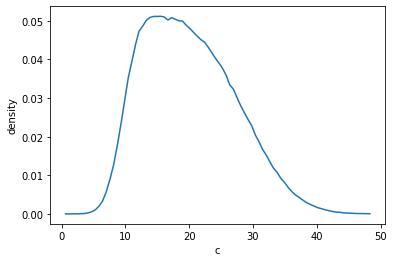

In [30]:
out = c.plot_pdf(show=True)

However, the underlying drawn values of the children distributions are still accessible.  Here we can see the values for the gaussian and uniform distributions that were drawn before applying multiplication.

In [31]:
c.cached_sample_children

array([10.91396087,  2.14845586])

In [32]:
c.cached_sample_children[0] * c.cached_sample_children[1]

23.44816323551863

If we wanted to, we could determine the individual probabilities of drawing these two components.

In [33]:
c.dist1.pdf(c.cached_sample_children[0]), c.dist2.pdf(c.cached_sample_children[1])

(0.17969374889690237, 0.5)

The probability of drawing this *set* of values from the children would then be the product (or the sum in the case of `logpdf`).

In [34]:
c.dist1.pdf(c.cached_sample_children[0]) * c.dist2.pdf(c.cached_sample_children[1])

0.08984687444845119

As you probably expect by now, the same logic holds when passing `size` to `sample`.

In [35]:
c.sample(size=2)

array([23.44816324, 12.95003355])

In [36]:
c.cached_sample

array([23.44816324, 12.95003355])

In [37]:
c.cached_sample_children

array([[10.91396087,  9.19345783],
       [ 2.14845586,  1.40861402]])

# Distribution Collection

In [38]:
dc = distl.DistributionCollection(g, mvg_a, c)

In [39]:
dc

In [40]:
dc.sample()

array([11.27173285,  6.6477602 , 32.49904246])

For collections, `cached_sample` refers to the passed `distributions`...

In [41]:
dc.cached_sample

array([11.27173285,  6.6477602 , 32.49904246])

In [42]:
dc.labels

['g', 'a', 'c']

... whereas `cached_samples_unpacked` refers to the unpacked list of all underlying distributions (i.e. composite distributions are broken down into their subcomponents so that all the actual drawn values can be recorded to track covariances).

In [43]:
dc.cached_sample_unpacked

array([11.27173285,  6.6477602 , 11.27173285,  2.88323392])

In [44]:
dc.labels_unpacked

['g', 'a', 'g', 'u']

We can notice a few things here.  The first is that `u` shows up twice (as it is returned in the sample but also used in the math to compute `c`), and is given the same value in both cases.  Furthermore, `c` was defined as `g * u`, which we can confirm here by doing math on the cached values.

In [45]:
dc.cached_sample_unpacked[2] * dc.cached_sample_unpacked[3], dc.cached_sample[2]

(32.49904245599096, 32.49904245599096)

We can also see that the covariances are respected by plotting.  For more details, see the [DistributionCollections examples](./collections.ipynb).

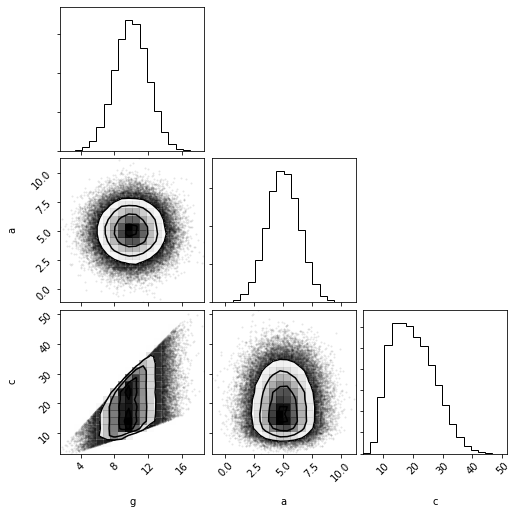

In [46]:
out = dc.plot(show=True)

Now if we rely on the cached values when calling [pdf](../api/DistributionCollection.pdf.md) it will default to passing [cached_sample_unpacked](../api/DistributionCollection.cached_sample_unpacked.md) (and ignoring duplicate entries when doing the sum/product), therefore accounting for covariances.

In [47]:
dc.pdf()

0.011658887736809443

To avoid this behavior and instead treat each of the three sampled values in their univariate forms, you can explicitly pass the non-unpacked cache (distl recognized that the length matches the sampled values directly and computes using the flattend univariates instead).

**NOTE**: if you're passing values manually to `pdf`, the length of the passed array must agree with `as_univariates`.  In some cases (like this one) the lengths are different and so an error will be raised if they're in disagreement.  But in other cases the lengths can be the same, and so the behavior will rely on the value of `as_univariates` which defaults to `False`.  See [collections examples](./collections.ipynb) for more details.

In [48]:
dc.pdf(as_univariates=True)

0.00032474896167878573